In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [14]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_HIBURAn.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,21316530,2007-01-01
1,2007-2,21316530,2007-02-01
2,2007-3,12489125,2007-03-01
3,2007-4,16572879,2007-04-01
4,2007-5,15386878,2007-05-01


In [15]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/hiburan.json', 'w') as f:
    json.dump(json_data, f) 

{"2007-01-01T00:00:00.000":21316530,"2007-02-01T00:00:00.000":21316530,"2007-03-01T00:00:00.000":12489125,"2007-04-01T00:00:00.000":16572879,"2007-05-01T00:00:00.000":15386878,"2007-06-01T00:00:00.000":15599971,"2007-07-01T00:00:00.000":30166607,"2007-08-01T00:00:00.000":41716053,"2007-09-01T00:00:00.000":14474799,"2007-10-01T00:00:00.000":9011792,"2007-11-01T00:00:00.000":36495360,"2007-12-01T00:00:00.000":17300614,"2008-01-01T00:00:00.000":29721840,"2008-02-01T00:00:00.000":18976443,"2008-03-01T00:00:00.000":9744651,"2008-04-01T00:00:00.000":13150625,"2008-05-01T00:00:00.000":13461523,"2008-06-01T00:00:00.000":19653125,"2008-07-01T00:00:00.000":31227815,"2008-08-01T00:00:00.000":31545540,"2008-09-01T00:00:00.000":15788349,"2008-10-01T00:00:00.000":4630633,"2008-11-01T00:00:00.000":37184962,"2008-12-01T00:00:00.000":16413216,"2009-01-01T00:00:00.000":25762137,"2009-02-01T00:00:00.000":23297165,"2009-03-01T00:00:00.000":15536888,"2009-04-01T00:00:00.000":19449846,"2009-05-01T00:00:00.0

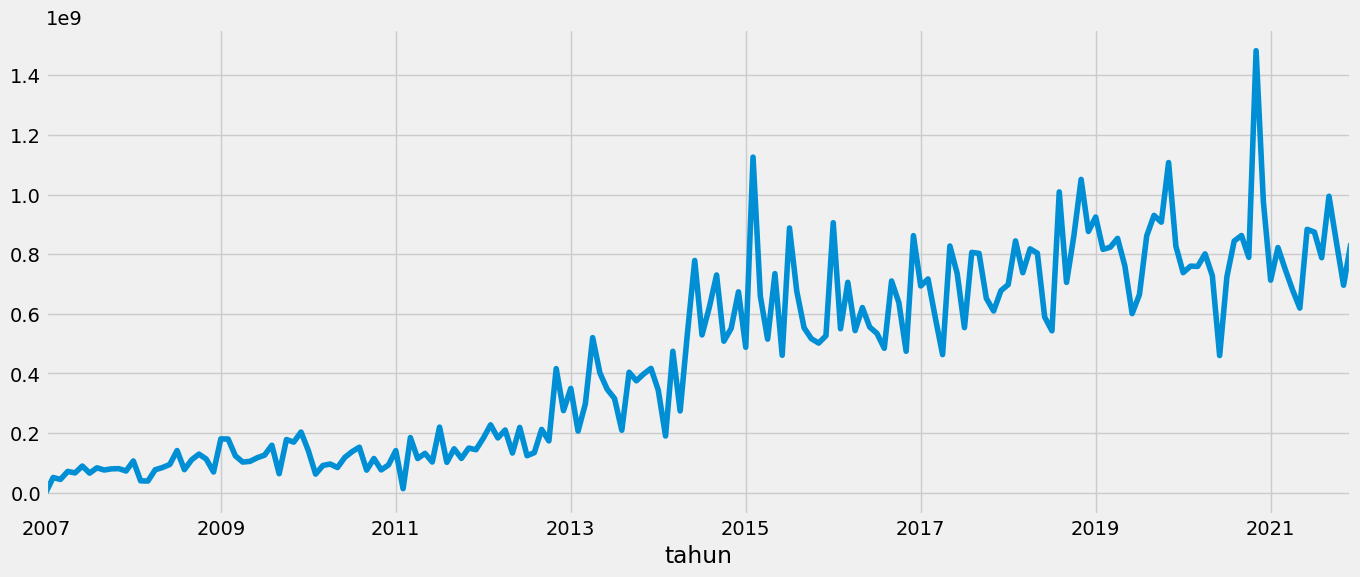

In [4]:
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [54]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 3
p = d = q = range(0, 3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [55]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [[0, 0, 1],[0, 0, 1, 12]]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 7241.409927875922
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 6707.67886279296
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 6237.862365551835
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 6668.946167464296
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 6188.6288767711085
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 5729.664767413136
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 6323.49453139825
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 5769.096774104603
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 5321.824943825588
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 6684.813559285895
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 6648.793099210754
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC: 6187.299760827539
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 6234.324396958009
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 6184.459406378734
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 5727.341809505823
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC: 5830.696953423872
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 5745.191775654808
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 5289.557888

In [56]:
best_result = [[0, 0, 1], [0, 0, 1, 12]]

# Plot model diagnostics

In [57]:
mod = sm.tsa.statespace.SARIMAX(dts,
                                order=(best_result[0][0], best_result[0][1], best_result[0][2]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=True,
                                enforce_invertibility=True,)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -3588.750
Date:                            Wed, 28 Dec 2022   AIC                           7183.500
Time:                                    08:09:58   BIC                           7193.079
Sample:                                01-01-2007   HQIC                          7187.384
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4734      0.110      4.300      0.000       0.258       0.689
ma.S.L12       0.4390      0.078   

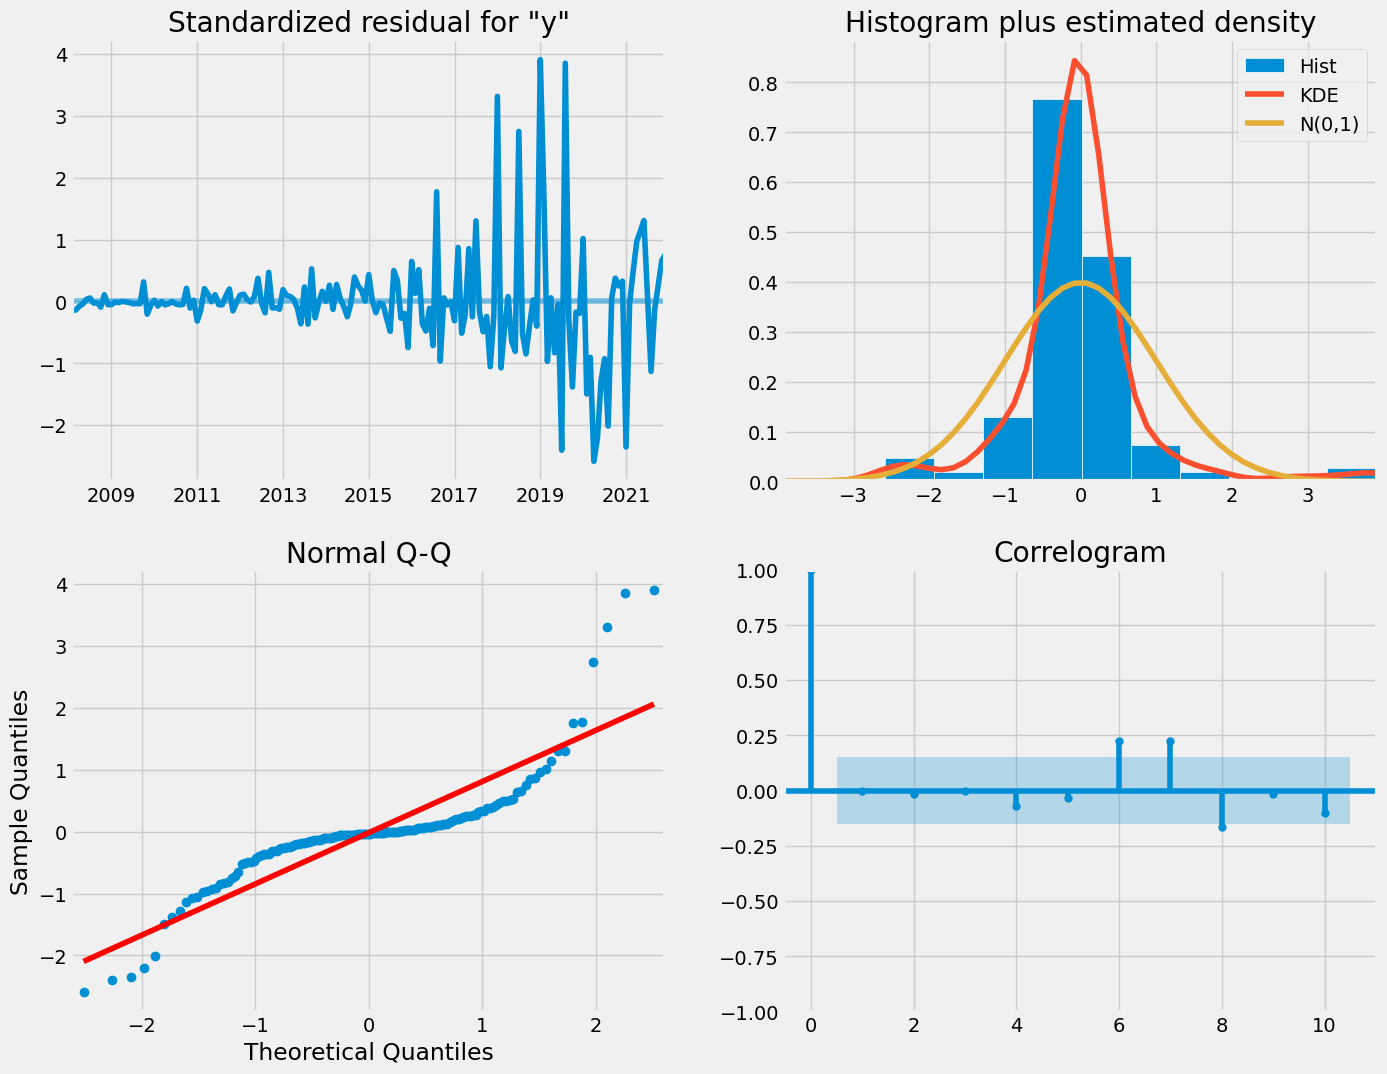

In [36]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [58]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

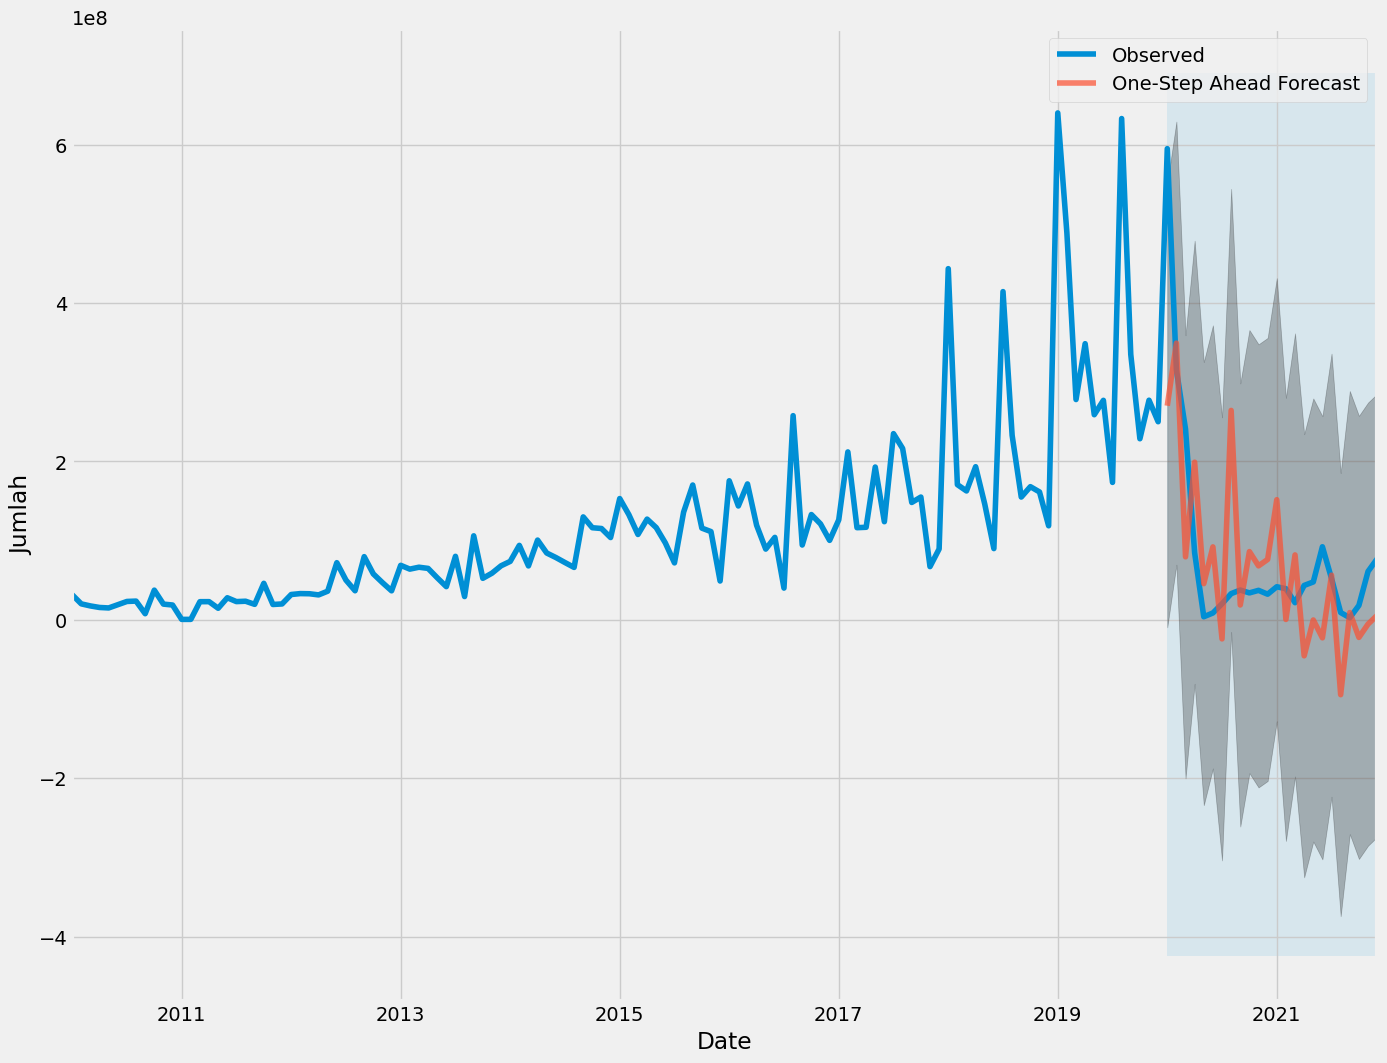

In [59]:
ax = dts['2010':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Jumlah')
plt.legend()

plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = dts['2020-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error forecasts adalah {}'.format(round(mse, 2)))

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [ ]:
ax = dts['2010':].plot(label='Observed', figsize=(15, 12))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')

plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [60]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60)
# Dapatkan interval
pred_ci = pred_uc.conf_int()
json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/hiburan_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":-23580693.7520892099,"2022-02-01T00:00:00.000":-5802655.4614704624,"2022-03-01T00:00:00.000":-18420790.6893169545,"2022-04-01T00:00:00.000":26464041.6049659252,"2022-05-01T00:00:00.000":39547613.3508768082,"2022-06-01T00:00:00.000":60448995.6574331224,"2022-07-01T00:00:00.000":22006079.3396719508,"2022-08-01T00:00:00.000":44624974.4360476583,"2022-09-01T00:00:00.000":18684830.1485089399,"2022-10-01T00:00:00.000":16389470.8289798368,"2022-11-01T00:00:00.000":37595076.5148737207,"2022-12-01T00:00:00.000":45151215.5666518956,"2023-01-01T00:00:00.000":14832600.0656874143,"2023-02-01T00:00:00.000":0.0,"2023-03-01T00:00:00.000":0.0,"2023-04-01T00:00:00.000":0.0,"2023-05-01T00:00:00.000":0.0,"2023-06-01T00:00:00.000":0.0,"2023-07-01T00:00:00.000":0.0,"2023-08-01T00:00:00.000":0.0,"2023-09-01T00:00:00.000":0.0,"2023-10-01T00:00:00.000":0.0,"2023-11-01T00:00:00.000":0.0,"2023-12-01T00:00:00.000":0.0,"2024-01-01T00:00:00.000":0.0,"2024-02-01T00:00:00.000":0.0,"2024-03-

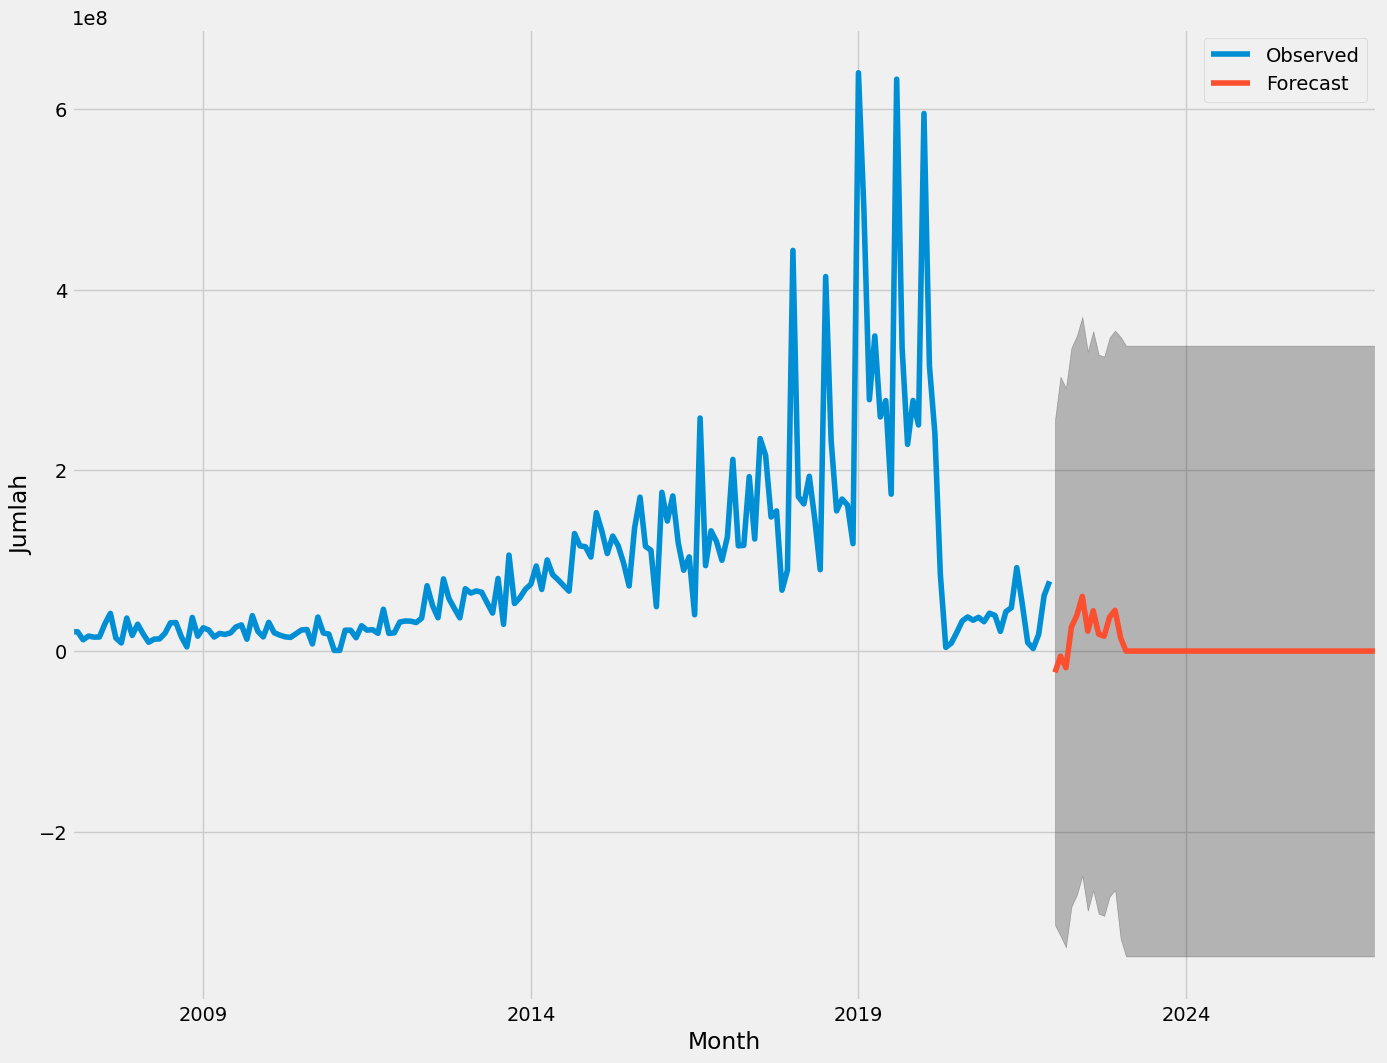

In [61]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')

plt.legend()
plt.show()